# Prosumer Load Shifting ABM model V3

## Model structure
#### Data preparation
- create_agent_data

#### Model setup

- create_agents
- connect_agents / create_network

#### Agent logic

- shift_load
- calculate_behaviour

#### Simulation

- simulation 
- save_data

In [23]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import itertools
import random
import copy
import pandas as pd
import networkx as nx
from matplotlib import animation
import seaborn as sns
plt.style.use("seaborn-dark-palette")
sns.set(style='ticks') 
from sklearn import preprocessing as prep    

## Izdelava agentovih podatkov

Prva funkcija je namenjena generiranju naključnih skupin

In [24]:
def create_agent_data(number_of_agents):
    #load schedhule and load data
    data = pd.read_excel(r'data/basic_load_profile.xlsx')
    data = data.set_index('time')
    #store data in schedule dictionary key=hour, pair= load [kW]
    schedule = {}

    for index, row in data.iterrows():
        schedule[index] = row['load_1']
    print(schedule)

    # create groups
    groups = ['eco', 'normal', 'trad']
    # create dataframe to store agent info
    data_frame = pd.DataFrame(columns= ['id'])

    # for each agent add following attributes
    for agent in range(number_of_agents):
        group = groups[random.randint(0,len(groups)-1)] #choose random group from group list
        group_weight = 0 # assign initial group weight
        # assign weights for each group
        if group == 'eco':
            group_weight = 0.1
            flexibility_coeficient = 0.8
            conv_weight = 0.5
            price_weight = 0.5
        elif group == 'normal':
            group_weight = 0.1
            flexibility_coeficient = 0.5
            conv_weight = 1
            price_weight = 0.5
        elif group == 'trad':
            group_weight = 0.1
            flexibility_coeficient = 0.3
            conv_weight = 1
            price_weight = 1



        data = {'id': agent,
                'schedule': schedule,
                'group_weight': group_weight,
                'flexibility_coeficient': flexibility_coeficient,
                'susceptibility': 0.1,
                'group': group,
                #'group_weight': group_weight,
                'load_shifts': 0,
                'conv_weight': conv_weight,
                'price_weight': price_weight
                }

        data_frame = data_frame.append(data, ignore_index=True)
    #print(data_frame.index.tolist())
    return data_frame.set_index('id')# Return dataframve with index ID 

Druga funkcija je namenjena točnemu številu agentov skupin

In [27]:
def create_agent_data2(num_eco,num_trad,num_normal):
    #load schedhule and load data
    data = pd.read_excel(r'data/basic_load_profile.xlsx')
    
    data = data.set_index('time')
    #store data in schedule dictionary key=hour, pair= load [kW]
    schedule = {}
    susceptibility = 0.1
    group_weight = 0.1

    for index, row in data.iterrows():
        schedule[index] = row['load_1']
    print("Printed schedule", schedule)

    # create groups
    groups = ['eco', 'normal', 'trad']
    # create dataframe to store agent info
    data_frame = pd.DataFrame(columns= ['id'])

    # for each agent add following attributes
    for agent in range(num_eco):
        group = groups[0]
        group_weight = group_weight
        flexibility_coeficient = 0.8
        # shift length weight
        conv_weight = 0.5
        price_weight = 0.5

        data = {
            'schedule': schedule,
            'group_weight': group_weight,
            'flexibility_coeficient': flexibility_coeficient,
            'susceptibility': susceptibility,
            'group': group,
            #'group_weight': group_weight,
            'load_shifts': 0,
            'conv_weight': conv_weight,
            'price_weight': price_weight,
            'shift_counter': 0
        }
        data_frame = data_frame.append(data, ignore_index=True)

    for agent in range(num_normal):
        group = groups[1]
        group_weight = group_weight
        flexibility_coeficient = 0.5
        conv_weight = 1
        price_weight = 0.5

        data = {
            'schedule': schedule,
            'group_weight': group_weight,
            'flexibility_coeficient': flexibility_coeficient,
            'susceptibility': susceptibility,
            'group': group,
            #'group_weight': group_weight,
            'load_shifts': 0,
            'conv_weight': conv_weight,
            'price_weight': price_weight,
            'shift_counter': 0
            }
        data_frame = data_frame.append(data, ignore_index=True)

    for agent in range(num_trad):
        group = groups[2]
        group_weight = group_weight
        flexibility_coeficient = 0.3
        conv_weight = 1
        price_weight = 1

        data = {'schedule': schedule,
                'group_weight': group_weight,
                'flexibility_coeficient': flexibility_coeficient,
                'susceptibility': susceptibility,
                'group': group,
                #'group_weight': group_weight,
                'load_shifts': 0,
                'conv_weight': conv_weight,
                'price_weight': price_weight,
                'shift_counter': 0
                }
        

        data_frame = data_frame.append(data, ignore_index=True)

    data_frame.insert(0,'New_id', range(0,len(data_frame)))
    #print(data_frame.index.tolist())
    return data_frame.set_index('New_id')# Return dataframve with index ID 

## Priprava deležov skupin

In [28]:
# prepare data with function create_agent_data and save it in variable 
#random agent data
#new_agent_data = create_agent_data(12)
#fixed agent data
new_agent_data = create_agent_data2(4,4,4)
new_agent_data.to_csv('output/random_agentdata.csv')
new_agent_data

Printed schedule {1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.2, 6: 0.1, 7: 0.1, 8: 0.1, 9: 0.1, 10: 0.1, 11: 0.1, 12: 0.1, 13: 0.1, 14: 0.1, 15: 1.5, 16: 1.5, 17: 0.1, 18: 2.0, 19: 3.0, 20: 2.0, 21: 1.0, 22: 0.2, 23: 0.2, 24: 0.1}


,id,conv_weight,flexibility_coeficient,group,group_weight,load_shifts,price_weight,schedule,shift_counter,susceptibility
New_id,,,,,,,,,,
0,NaN,0.5,0.8,eco,0.1,0.0,0.5,"{1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.2, 6: 0....",0.0,0.1
1,NaN,0.5,0.8,eco,0.1,0.0,0.5,"{1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.2, 6: 0....",0.0,0.1
2,NaN,0.5,0.8,eco,0.1,0.0,0.5,"{1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.2, 6: 0....",0.0,0.1
3,NaN,0.5,0.8,eco,0.1,0.0,0.5,"{1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.2, 6: 0....",0.0,0.1
4,NaN,1.0,0.5,normal,0.1,0.0,0.5,"{1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.2, 6: 0....",0.0,0.1
5,NaN,1.0,0.5,normal,0.1,0.0,0.5,"{1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.2, 6: 0....",0.0,0.1
6,NaN,1.0,0.5,normal,0.1,0.0,0.5,"{1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.2, 6: 0....",0.0,0.1
7,NaN,1.0,0.5,normal,0.1,0.0,0.5,"{1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.2, 6: 0....",0.0,0.1
8,NaN,1.0,0.3,trad,0.1,0.0,1.0,"{1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.2, 6: 0....",0.0,0.1


## Funkcija za izdelavo agentov

In [29]:
#create empty graph for further use
consumer_network = nx.Graph()

def create_agents(agent_data, network):
    for index, row in agent_data.iterrows(): # for each row in agent data add new node to graph and add data
        # for each agent, add new node
        network.add_node(index)
        network.nodes[index]['schedule'] = row['schedule']
        #network.nodes[index]['schedule'] = {1: 'empty', 2: 'empty', 3: 'empty', 4: 'empty', 5: 'empty', 6: 'empty', 7: 'empty', 8: 'empty', 9: 'empty', 10: 'empty', 11: 'empty', 12: 'empty', 13: 'empty', 14: 'empty', 15: 'empty', 16: 'empty', 17: 'empty', 18: 'flexible', 19: 'empty', 20: 'empty', 21: 'empty', 22: 'empty', 23: 'empty', 24: 'empty'}
        network.nodes[index]['flexibility_coeficient'] = row['flexibility_coeficient']
        network.nodes[index]['susceptibility'] = row['susceptibility']
        network.nodes[index]['group'] = row['group']
        network.nodes[index]['group_weight'] = row['group_weight']
        network.nodes[index]['load_shifts'] = row['load_shifts']
        network.nodes[index]['conv_weight'] = row['conv_weight']
        network.nodes[index]['price_weight'] = row['price_weight']
        network.nodes[index]['shift_counter'] = row['shift_counter']
        
    #set network position to circle
    #pos = nx.random_layout(network)
    #draw graph
    #plt.figure(figsize = (9, 6)) 
    #print(network.nodes.data())
    #nx.draw_networkx(network,pos)
    return network

In [30]:
test = create_agents(new_agent_data, consumer_network)
#test2 = create_agents(new_agent_data, consumer_network)
test.nodes.data()

NodeDataView({0: {'schedule': {1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.2, 6: 0.1, 7: 0.1, 8: 0.1, 9: 0.1, 10: 0.1, 11: 0.1, 12: 0.1, 13: 0.1, 14: 0.1, 15: 1.5, 16: 1.5, 17: 0.1, 18: 2.0, 19: 3.0, 20: 2.0, 21: 1.0, 22: 0.2, 23: 0.2, 24: 0.1}, 'flexibility_coeficient': 0.8, 'susceptibility': 0.1, 'group': 'eco', 'group_weight': 0.1, 'load_shifts': 0.0, 'conv_weight': 0.5, 'price_weight': 0.5, 'shift_counter': 0.0}, 1: {'schedule': {1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.2, 6: 0.1, 7: 0.1, 8: 0.1, 9: 0.1, 10: 0.1, 11: 0.1, 12: 0.1, 13: 0.1, 14: 0.1, 15: 1.5, 16: 1.5, 17: 0.1, 18: 2.0, 19: 3.0, 20: 2.0, 21: 1.0, 22: 0.2, 23: 0.2, 24: 0.1}, 'flexibility_coeficient': 0.8, 'susceptibility': 0.1, 'group': 'eco', 'group_weight': 0.1, 'load_shifts': 0.0, 'conv_weight': 0.5, 'price_weight': 0.5, 'shift_counter': 0.0}, 2: {'schedule': {1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.2, 6: 0.1, 7: 0.1, 8: 0.1, 9: 0.1, 10: 0.1, 11: 0.1, 12: 0.1, 13: 0.1, 14: 0.1, 15: 1.5, 16: 1.5, 17: 0.1, 18: 2.0, 19: 3.0, 20: 2.0

In [31]:
test.nodes[1]

{'schedule': {1: 0.1,
  2: 0.1,
  3: 0.1,
  4: 0.1,
  5: 0.2,
  6: 0.1,
  7: 0.1,
  8: 0.1,
  9: 0.1,
  10: 0.1,
  11: 0.1,
  12: 0.1,
  13: 0.1,
  14: 0.1,
  15: 1.5,
  16: 1.5,
  17: 0.1,
  18: 2.0,
  19: 3.0,
  20: 2.0,
  21: 1.0,
  22: 0.2,
  23: 0.2,
  24: 0.1},
 'flexibility_coeficient': 0.8,
 'susceptibility': 0.1,
 'group': 'eco',
 'group_weight': 0.1,
 'load_shifts': 0.0,
 'conv_weight': 0.5,
 'price_weight': 0.5,
 'shift_counter': 0.0}

# Ustvari omrežje - >Topologijo
### Naključno omrežje 

In [32]:
def connect_agents_random(network):
    # save agents to list 
    nodesList = list(network.__iter__())

    # loop trough agents
    for node in network.__iter__():
        # add edge to agent from a list of all agents
        network.add_edge(node, nodesList[random.randint(0,len(nodesList)-1)])
        network.add_edge(node, nodesList[random.randint(0,len(nodesList)-1)])
                         
        # add list of all neighbours to agent atributes
        network.nodes[node]['neighbours'] = list(network.neighbors(node))
        
    #set node color 
    color_map = ['tomato' if network.nodes[node]['group'] == 'trad' else 'deepskyblue' if network.nodes[node]['group'] == 'normal' else 'limegreen' for node in network]     
    

    network.remove_edges_from(list(nx.selfloop_edges(network)))
    # draw network graph
    pos = nx.circular_layout(network)
    plt.figure(figsize = (16, 16))
    nx.draw_networkx(network, pos, node_color= color_map, linewidths=5)  
    #nx.draw_networkx(network, pos)  
    return network

### Polnopovezano omrežje 

In [33]:
def connect_agents_fullyconnected(network):
    # save agents to list 
    agents = network.number_of_nodes()
    fully_connected = nx.complete_graph(agents)
    edges = fully_connected.edges

    network.add_edges_from(edges)
    pos = nx.circular_layout(network)

    for node in network.__iter__():
        network.nodes[node]['neighbours'] = list(network.neighbors(node))

     #set node color 
    color_map = ['tomato' if network.nodes[node]['group'] == 'trad' else 'deepskyblue' if network.nodes[node]['group'] == 'normal' else 'limegreen' for node in network]

    plt.figure(figsize = (16, 16))
    nx.draw_networkx(network, pos, node_color= color_map, linewidths=5)  
    return network

### Small world omrežje

In [34]:
def connect_agents_smallworld(network):
    # save agents to list 
    agents = network.number_of_nodes()
    small_world = nx.watts_strogatz_graph(n = agents, k = 4, p=0.2)
    edges = small_world.edges

    network.add_edges_from(edges)
    pos = nx.circular_layout(network)

    for node in network.__iter__():
        network.nodes[node]['neighbours'] = list(network.neighbors(node))

     #set node color 
    color_map = ['tomato' if network.nodes[node]['group'] == 'trad' else 'deepskyblue' if network.nodes[node]['group'] == 'normal' else 'limegreen' for node in network]

    plt.figure(figsize = (16,16))
    nx.draw_networkx(network, pos, node_color= color_map, linewidths=5)  
    #nx.draw_networkx(network, pos)  
    return network

<bound method OutEdgeView.data of EdgeView([(0, 5), (0, 10), (0, 1), (1, 2), (1, 3), (1, 9), (3, 6), (4, 8), (4, 11), (5, 6), (5, 11), (5, 8), (5, 10), (6, 8), (6, 11), (7, 8), (7, 9), (8, 10), (10, 11)])>


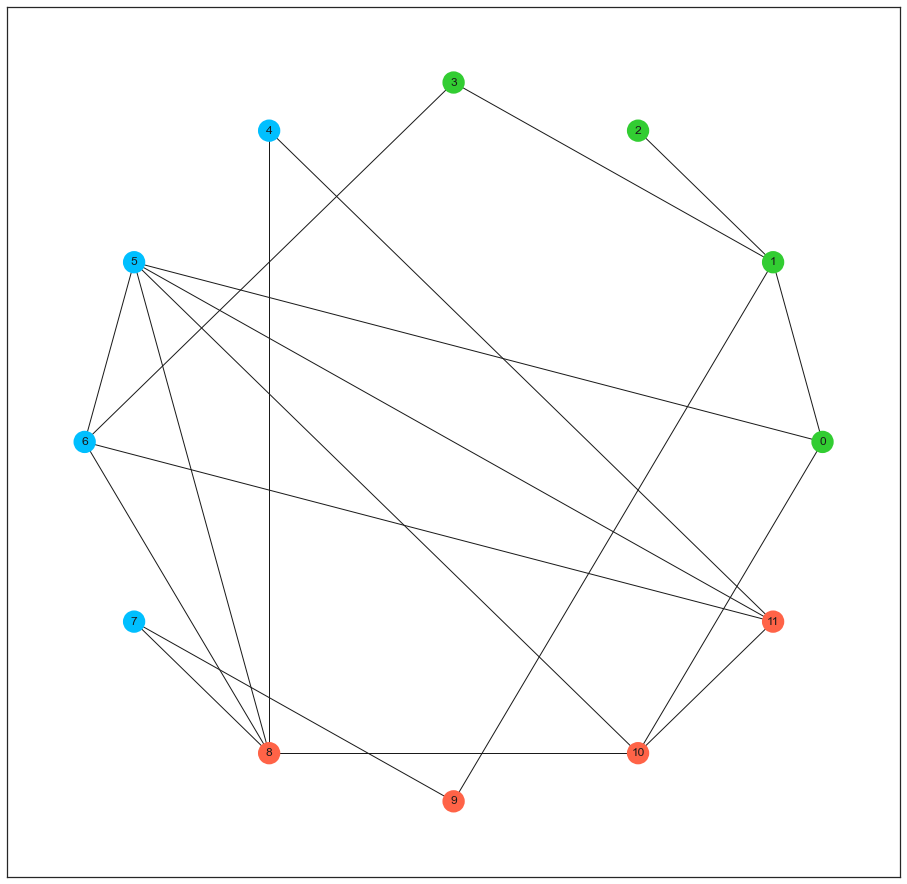

In [35]:
# connect agents on test network and check if it works
test = connect_agents_random(test)
#test = connect_agents_fullyconnected(test)
#test = connect_agents_smallworld(test)
print(test.edges.data)

In [36]:
print("St edgov",test.number_of_edges())
print("Povpr. rojenje", nx.average_clustering(test))
print("Povpr. najkrasa pot", nx.average_shortest_path_length(test))
print("Najmocnejsi clen", max(nx.betweenness_centrality(test).values()))

St edgov 19
Povpr. rojenje 0.18333333333333332
Povpr. najkrasa pot 2.121212121212121
Najmocnejsi clen 0.2911255411255411


## Odločitvena logika agentov 

In [37]:
#testschedule
test_schedule = {1: 'empty', 2: 'empty', 3: 'empty', 4: 'empty', 5: 'empty', 6: 'empty', 7: 'empty', 8: 'empty', 9: 'empty', 10: 'empty', 11: 'empty', 12: 'empty', 13: 'empty', 14: 'empty', 15: 'empty', 16: 'empty', 17: 'empty', 18: 'flexible', 19: 'empty', 20: 'empty', 21: 'empty', 22: 'empty', 23: 'empty', 24: 'empty'}

In [38]:

def coordinator(time_frame, load):
    # on obdela podatke cene in zamika, jih normalizira in pošlje naprej, tako da za shift_load dobi samo normalizirane vrednosti
    tariff_data = []
    load_data = []
    return load_data, tariff_data#, price_signal, load_signal

# agent -> all curent agent data | network -> network data | time_frame -> current hour
def shift_load(agent, network, time_frame):
    # set data for testing 
    electricity_price = [[0.1, 0.25]]
    shift_length = [[3,6]]
    # set initial atractivity 
    att = 0 

    # get data from agent -> load weight and shift weigh
    agent_Sw = network.nodes[agent]['conv_weight'] 
    agent_Pw = network.nodes[agent]['price_weight']
    # calibration weight
    Kw = 0.6

    # normalise price and shift length
    pN = prep.normalize(electricity_price, norm="l1")
    sN = prep.normalize(shift_length, norm="l1")

    # electricty price signl for each tariff
    if 6 <= time_frame < 22:
        
        price_signal = pN[0][1] #high price
    else:
        price_signal = pN[0][0] #low price

    # shift signal, depends on lenght
    # short shift [0][0] 
    # long shift [0][1]
    shift_signal = sN[0][1]

    # weights normalization
    wN = prep.normalize([[agent_Pw, agent_Sw, Kw]], norm="l1")
    #print("Agent group: ",network.nodes[agent]['group'],"| Normalised weights: ", wN)

    # calculate atractivyt of load 
    # this wil set treshold for shifting load
    att = (wN[0][0] * price_signal) + (wN[0][1] * shift_signal)

    # counter for counting how many shifts were done 
    shift_counter = 0
    # get current shifts 
    current_counts = network.nodes[agent]['load_shifts'] 
    # counter for hours
        
    # counter for kw 


    #print("Flex",network.nodes[agent]['flexibility_coeficient'],"Att:",att," Load kw",network.nodes[agent]['schedule'][time_frame])
    # rule fol shifting load based on flexibilty coeficient of an agent and 
    if network.nodes[agent]['flexibility_coeficient'] > att and network.nodes[agent]['schedule'][time_frame] > 2.5:
        #shift_counter = shift_counter + 1
        current_counts = current_counts + 1
        
        #print(shift_counter)

    # update agent's counter
    network.nodes[agent]['load_shifts'] =+ current_counts 

    #time_frame = network.nodes[agent]['schedule'][time_frame]
    #print(time_frame, price_signal)
    #print(time_frame, att)
    #print("Load atractivity at:", time_frame," = ", att )
    #print(shift_signal)
    
    return current_counts

    

    


In [39]:
test.nodes[1]['schedule'][19]

3.0

In [40]:

for i in range(1,24):
    shift_load(10,test,i)

In [41]:
#shift_load(1, test, 18)
print(test.nodes[1])

def restart_schedule(agent, network):
    network.nodes[agent]['schedule'] = test_schedule

#restart_schedule(1,test)
#test.nodes[1]

{'schedule': {1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.2, 6: 0.1, 7: 0.1, 8: 0.1, 9: 0.1, 10: 0.1, 11: 0.1, 12: 0.1, 13: 0.1, 14: 0.1, 15: 1.5, 16: 1.5, 17: 0.1, 18: 2.0, 19: 3.0, 20: 2.0, 21: 1.0, 22: 0.2, 23: 0.2, 24: 0.1}, 'flexibility_coeficient': 0.8, 'susceptibility': 0.1, 'group': 'eco', 'group_weight': 0.1, 'load_shifts': 0.0, 'conv_weight': 0.5, 'price_weight': 0.5, 'shift_counter': 0.0, 'neighbours': [2, 0]}


In [42]:
test.nodes[2]['susceptibility']

0.1

# Obnašanje agentov

In [43]:
def behaviour(agent, agent_network):
     # creat list of agetns neigbours
    neighbour_list = agent_network.nodes[agent]['neighbours']

    # create empty list and store behaviour of each neighbour
    # in this case that is flexibility_coeficient
    behaviour_list = []
    weight_list = []


    # collect neighbours behaviour and weights and add them to the lists
    for neighbour in neighbour_list:
        behaviour_list.append(agent_network.nodes[neighbour]['flexibility_coeficient'])
        if agent_network.nodes[neighbour]['group'] == agent_network.nodes[agent]['group']:
            weight_list.append(0.1)
        else:
            weight_list.append(0.1)
    #print('weight List: ', weight_list)  
    
    # get current agent flexibility 
    agent_current_flexibility = agent_network.nodes[agent]['flexibility_coeficient']
    #print('Agents start flexibility', agent_current_flexibility)
    
    # set variable B, so it repsresents agent's current behaviour
    B = agent_network.nodes[agent]['flexibility_coeficient']

    # calculate behaviour diffusion
    new_B = B + agent_network.nodes[agent]['susceptibility'] * (sum(behaviour_list[n] * weight_list[n] for n in range(len          (behaviour_list)))/ sum(weight_list) - B)


    # update agent's behaviour inside network dictionary
    agent_network.nodes[agent]['flexibility_coeficient'] = new_B
    #print('Agents new flexibility', new_B)

    #return agent_network.nodes[agent]['flexibility_coeficient']
    return agent_current_flexibility

In [44]:
#testni_behaviour = behaviour(1, test)
#testni_behaviour

# Simulation

In [45]:
def simulation(network, days, schedule):
    day_frame1 = {}
    day_frame2 = {}
    key_frame = {}
    for day in range(0,days): #counter za 50 iteracij

        #df = pd.DataFrame(columns =('Day', 'Agent group'))
        export_data = {}
        export_data2 = {}
        export_key_data = {}
        print('Dan št:',day+1)
        for agent in network: 
        #v vsaki časovni enoti urnika nato obravnavamo vse agente, gremo preko seznama agenot in izračunamo obnašanje.
        # potem ni važno kako ali je po urah ali 15 min resolucijo
            
            for key in schedule:
                current_counts = shift_load(agent, network, key)
                agent_group = network.nodes[agent]['group']
                #export_key_data[agent_group, agent] = shift_counter
                key_frame[key] = export_key_data
                #agent_shift_counter = network.nodes[agent]['load_shifts'] + shift_counter

            # agent_group = network.nodes[agent]['group']
            agent_flexibility = network.nodes[agent]['flexibility_coeficient']
            export_data2[agent_group, agent] = agent_flexibility

            agent_shift_counter = network.nodes[agent]['load_shifts']
            export_data[agent_group, agent] = agent_shift_counter

            
            # calculate     
            agent_flexibility = round(behaviour(agent, network),3)
            
            #restart_schedule(agent,network)

            day_frame1[day+1] = export_data
            day_frame2[day+1] = export_data2
            

    df = pd.DataFrame.from_dict(day_frame1)
    df2 = pd.DataFrame.from_dict(day_frame2)
    df3_keys = pd.DataFrame.from_dict(key_frame)
    return network, df, df2, df3_keys

## Izpis podatkov 
 - results -> network data 
 - exported_data -> premiki ure
 - exported_data2 -> flexibility coeficient
 - exported_keys -> keys for testing

## Izvedba simulacije

In [46]:
results, exported_data, exported_data2, exported_keys = simulation(test, 30, test_schedule)

Dan št: 1
Dan št: 2
Dan št: 3
Dan št: 4
Dan št: 5
Dan št: 6
Dan št: 7
Dan št: 8
Dan št: 9
Dan št: 10
Dan št: 11
Dan št: 12
Dan št: 13
Dan št: 14
Dan št: 15
Dan št: 16
Dan št: 17
Dan št: 18
Dan št: 19
Dan št: 20
Dan št: 21
Dan št: 22
Dan št: 23
Dan št: 24
Dan št: 25
Dan št: 26
Dan št: 27
Dan št: 28
Dan št: 29
Dan št: 30


In [47]:
exported_keys

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24


In [48]:
# export za število premikov
# nastavi indexe
exported_data.index.names = ['Group','Id']
exported_data.index.droplevel(level=0)
exported_data

1    2    3    4    5    6    7    8    9     10  ...    21    22  \
Group  Id                                                     ...               
eco    0   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  ...  21.0  22.0   
       1   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  ...  21.0  22.0   
       2   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  ...  21.0  22.0   
       3   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  ...  21.0  22.0   
normal 4   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0  ...   1.0   1.0   
       5   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  ...  21.0  22.0   
       6   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  ...  21.0  22.0   
       7   1.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   2.0  ...   2.0   2.0   
trad   8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   0.0   0.0   
       9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   7.0   8.0   
       10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   0.0   0.0   
       11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   0.0   0.0   

             23    24    25    26    27    28    29    30  
Group  Id                                                  
eco    0   23.0  24.0  25.0  26.0  27.0  28.0  29.0  30.0  
       1   23.0  24.0  25.0  26.0  27.0  28.0  29.0  30.0  
       2   23.0  24.0  25.0  26.0  27.0  28.0  29.0  30.0  
       3   23.0  24.0  25.0  26.0  27.0  28.0  29.0  30.0  
normal 4    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  
       5   23.0  24.0  25.0  26.0  27.0  28.0  29.0  30.0  
       6   23.0  24.0  25.0  26.0  27.0  28.0  29.0  30.0  
       7    2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  
trad   8    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
       9    9.0  10.0  11.0  12.0  13.0  14.0  15.0  16.0  
       10   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
       11   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[12 rows x 30 columns]

In [49]:

exported_data.to_excel('output/output_premiki.xlsx')
print(exported_data)

#df = pd.DataFrame.from_dict(exported_data, orient='index')
#df.set_index(['Agent_group', 'Agent'],)

            1    2    3    4    5    6    7    8    9     10  ...    21    22  \
Group  Id                                                     ...               
eco    0   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  ...  21.0  22.0   
       1   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  ...  21.0  22.0   
       2   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  ...  21.0  22.0   
       3   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  ...  21.0  22.0   
normal 4   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0  ...   1.0   1.0   
       5   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  ...  21.0  22.0   
       6   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  ...  21.0  22.0   
       7   1.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   2.0  ...   2.0   2.0   
trad   8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   0.0   0.0   
       9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   7.0   8.0   
       10  0.0  0.0  0.0  0.

In [50]:
#exported_data.plot()
#exported_data.pivot(index='Id', columns=2)

In [51]:
#export za flexibility coeficient
exported_data2

1         2         3         4         5         6         7   \
eco    0   0.8  0.760000  0.725236  0.695004  0.668700  0.645799  0.625851   
       1   0.8  0.798000  0.794457  0.789743  0.784160  0.777953  0.771319   
       2   0.8  0.799900  0.799628  0.799134  0.798385  0.797363  0.796061   
       3   0.8  0.784900  0.771278  0.758924  0.747663  0.737347  0.727851   
normal 4   0.5  0.480000  0.463728  0.450622  0.440201  0.432050  0.425816   
       5   0.5  0.502000  0.503244  0.503913  0.504151  0.504075  0.503776   
       6   0.5  0.502897  0.505737  0.508467  0.511051  0.513462  0.515686   
       7   0.5  0.490000  0.481469  0.474210  0.468054  0.462854  0.458485   
trad   8   0.3  0.319372  0.336290  0.351091  0.364068  0.375472  0.385519   
       9   0.3  0.334400  0.364756  0.391478  0.414941  0.435487  0.453429   
       10  0.3  0.322712  0.342600  0.360007  0.375237  0.388558  0.400207   
       11  0.3  0.315190  0.329054  0.341724  0.353317  0.363939  0.373682   

                 8         9         10  ...        21        22        23  \
eco    0   0.608465  0.593305  0.580078  ...  0.509421  0.506821  0.504558   
       1   0.764413  0.757361  0.750260  ...  0.681387  0.676329  0.671467   
       2   0.794479  0.792623  0.790505  ...  0.754784  0.750861  0.746891   
       3   0.719071  0.710918  0.703316  ...  0.643151  0.639103  0.635220   
normal 4   0.421194  0.417926  0.415789  ...  0.428375  0.430766  0.433181   
       5   0.503326  0.502782  0.502186  ...  0.497401  0.497252  0.497145   
       6   0.517714  0.519546  0.521183  ...  0.529009  0.529075  0.529077   
       7   0.454837  0.451815  0.449337  ...  0.443044  0.443525  0.444095   
trad   8   0.394394  0.402256  0.409243  ...  0.452671  0.454919  0.457015   
       9   0.469048  0.482602  0.494322  ...  0.548888  0.549992  0.550771   
       10  0.410393  0.419298  0.427085  ...  0.469438  0.471127  0.472639   
       11  0.382630  0.390856  0.398426  ...  0.451898  0.454913  0.457723   

                 24        25        26        27        28        29  \
eco    0   0.502591  0.500886  0.499410  0.498138  0.497045  0.496111   
       1   0.666794  0.662303  0.657987  0.653835  0.649842  0.646000   
       2   0.742886  0.738857  0.734814  0.730765  0.726719  0.722683   
       3   0.631491  0.627909  0.624463  0.621147  0.617954  0.614877   
normal 4   0.435600  0.438006  0.440385  0.442728  0.445024  0.447268   
       5   0.497077  0.497044  0.497044  0.497072  0.497126  0.497203   
       6   0.529022  0.528918  0.528770  0.528585  0.528368  0.528125   
       7   0.444741  0.445452  0.446220  0.447036  0.447893  0.448784   
trad   8   0.458974  0.460812  0.462542  0.464173  0.465716  0.467179   
       9   0.551271  0.551531  0.551589  0.551473  0.551213  0.550831   
       10  0.473996  0.475221  0.476332  0.477345  0.478274  0.479129   
       11  0.460343  0.462789  0.465073  0.467209  0.469208  0.471080   

                 30  
eco    0   0.495316  
       1   0.642300  
       2   0.718664  
       3   0.611910  
normal 4   0.449454  
       5   0.497300  
       6   0.527858  
       7   0.449704  
trad   8   0.468569  
       9   0.550348  
       10  0.479923  
       11  0.472836  

[12 rows x 30 columns]

In [52]:
exported_data2.to_excel('output/output_obnašanjeagentov2.xlsx')
exported_data2.to_csv('output/primer3Anormal.csv')

Text(0.5, 1.0, 'Difuzija vedenja')

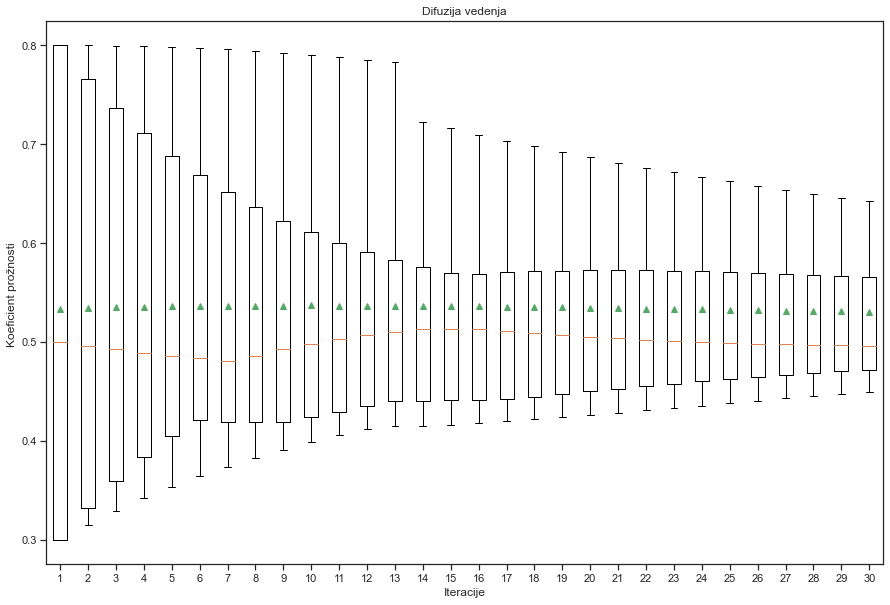

In [53]:

#figure texts
susc = results.nodes[0]['flexibility_coeficient']


fig = plt.figure(figsize =(15, 10))
bp = plt.boxplot(exported_data2,showmeans=True, showfliers=False)
plt.xlabel("Iteracije")
plt.ylabel("Koeficient prožnosti ")
plt.title("Difuzija vedenja")
#plt.legend(['legend'])
#plot = exported_data2.boxplot(grid=False)

In [56]:
exported_data2.index.names = ['Group','Id']
#exported_data2.groupby(['Group']).mean()
#type(exported_data2)
#sns.pointplot(data=exported_data2.groupby('Group', as_index=False).mean(), ax=bp)
exported_data2

1         2         3         4         5         6         7   \
Group  Id                                                                    
eco    0   0.8  0.760000  0.725236  0.695004  0.668700  0.645799  0.625851   
       1   0.8  0.798000  0.794457  0.789743  0.784160  0.777953  0.771319   
       2   0.8  0.799900  0.799628  0.799134  0.798385  0.797363  0.796061   
       3   0.8  0.784900  0.771278  0.758924  0.747663  0.737347  0.727851   
normal 4   0.5  0.480000  0.463728  0.450622  0.440201  0.432050  0.425816   
       5   0.5  0.502000  0.503244  0.503913  0.504151  0.504075  0.503776   
       6   0.5  0.502897  0.505737  0.508467  0.511051  0.513462  0.515686   
       7   0.5  0.490000  0.481469  0.474210  0.468054  0.462854  0.458485   
trad   8   0.3  0.319372  0.336290  0.351091  0.364068  0.375472  0.385519   
       9   0.3  0.334400  0.364756  0.391478  0.414941  0.435487  0.453429   
       10  0.3  0.322712  0.342600  0.360007  0.375237  0.388558  0.400207   
       11  0.3  0.315190  0.329054  0.341724  0.353317  0.363939  0.373682   

                 8         9         10  ...        21        22        23  \
Group  Id                                ...                                 
eco    0   0.608465  0.593305  0.580078  ...  0.509421  0.506821  0.504558   
       1   0.764413  0.757361  0.750260  ...  0.681387  0.676329  0.671467   
       2   0.794479  0.792623  0.790505  ...  0.754784  0.750861  0.746891   
       3   0.719071  0.710918  0.703316  ...  0.643151  0.639103  0.635220   
normal 4   0.421194  0.417926  0.415789  ...  0.428375  0.430766  0.433181   
       5   0.503326  0.502782  0.502186  ...  0.497401  0.497252  0.497145   
       6   0.517714  0.519546  0.521183  ...  0.529009  0.529075  0.529077   
       7   0.454837  0.451815  0.449337  ...  0.443044  0.443525  0.444095   
trad   8   0.394394  0.402256  0.409243  ...  0.452671  0.454919  0.457015   
       9   0.469048  0.482602  0.494322  ...  0.548888  0.549992  0.550771   
       10  0.410393  0.419298  0.427085  ...  0.469438  0.471127  0.472639   
       11  0.382630  0.390856  0.398426  ...  0.451898  0.454913  0.457723   

                 24        25        26        27        28        29  \
Group  Id                                                               
eco    0   0.502591  0.500886  0.499410  0.498138  0.497045  0.496111   
       1   0.666794  0.662303  0.657987  0.653835  0.649842  0.646000   
       2   0.742886  0.738857  0.734814  0.730765  0.726719  0.722683   
       3   0.631491  0.627909  0.624463  0.621147  0.617954  0.614877   
normal 4   0.435600  0.438006  0.440385  0.442728  0.445024  0.447268   
       5   0.497077  0.497044  0.497044  0.497072  0.497126  0.497203   
       6   0.529022  0.528918  0.528770  0.528585  0.528368  0.528125   
       7   0.444741  0.445452  0.446220  0.447036  0.447893  0.448784   
trad   8   0.458974  0.460812  0.462542  0.464173  0.465716  0.467179   
       9   0.551271  0.551531  0.551589  0.551473  0.551213  0.550831   
       10  0.473996  0.475221  0.476332  0.477345  0.478274  0.479129   
       11  0.460343  0.462789  0.465073  0.467209  0.469208  0.471080   

                 30  
Group  Id            
eco    0   0.495316  
       1   0.642300  
       2   0.718664  
       3   0.611910  
normal 4   0.449454  
       5   0.497300  
       6   0.527858  
       7   0.449704  
trad   8   0.468569  
       9   0.550348  
       10  0.479923  
       11  0.472836  

[12 rows x 30 columns]

In [57]:
exported_keys
exported_keys.to_excel('output/output_obnašanjeagentov_keys.xlsx')

In [58]:
#dataeco = pd.read_csv('/data/workspace_files/primer3Aeco.csv', index_col=[0,1])
#datatrad = pd.read_csv('/data/workspace_files/primer3Atrad.csv', index_col=[0,1])
#datanormal = pd.read_csv('/data/workspace_files/primer3Anormal.csv', index_col=[0,1])
#datatrad


fig, ax = plt.subplots(figsize=(15,10))
bp1 = ax.boxplot(dataeco,  widths=0.35, showmeans=True, showbox=False, showfliers=False, showcaps=False, meanline=True, meanprops={'color':'yellowgreen','linewidth': 8}, boxprops=None, labels=None, flierprops=None, medianprops={'color':'white','linewidth': 0}, whiskerprops={'color':'white','linewidth': 0} )
bp2 = ax.boxplot(datatrad, widths=0.35, showmeans=True, showbox=False, showfliers=False, showcaps=False, meanline=True, meanprops={'color':'tomato','linewidth': 8}, boxprops=None, labels=None, flierprops=None, medianprops={'color':'white','linewidth': 0}, whiskerprops={'color':'white','linewidth': 0})
bp3 = ax.boxplot(datanormal,  widths=0.35, showmeans=True, showbox=False, showfliers=False, showcaps=False, meanline=True, meanprops={'color':'steelblue','linewidth': 8}, boxprops=None, labels=None, flierprops=None, medianprops={'color':'white','linewidth': 0}, whiskerprops={'color':'white','linewidth': 0})

#ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['A', 'B', 'C'], loc='upper right')
plt.legend([bp1['means'][0], bp2['means'][2], bp3['means'][3]],['Mean ECO', 'Mean Traditional','Mean Normal'])
plt.title('Primer 3A')
plt.xlabel('Čas')
plt.ylabel('Koeficient prožnosti')

plt.show()

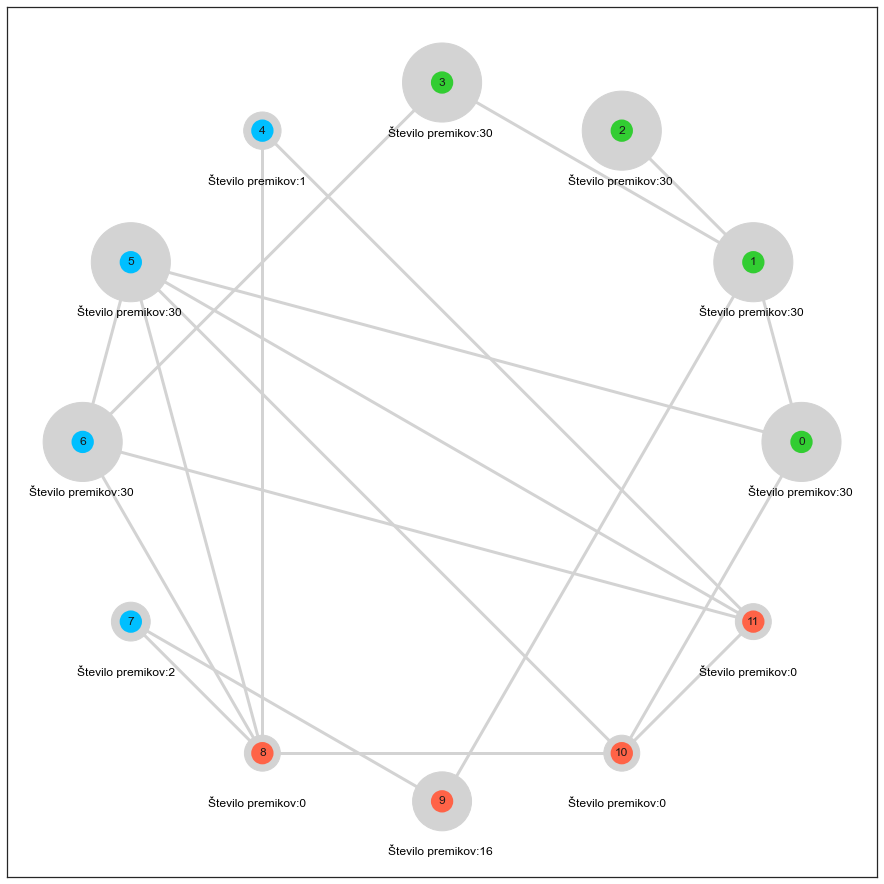

In [59]:

color_map = ['tomato' if results.nodes[node]['group'] == 'trad' else 'deepskyblue' if results.nodes[node]['group'] == 'normal' else 'limegreen' for node in results]
pos = nx.circular_layout(results)
centrality = nx.eigenvector_centrality_numpy(results)

plt.figure(figsize = (16, 16))
ax = plt.gca()
ax.set_aspect('equal')

nx.draw_networkx(results, pos, node_color= color_map, linewidths=5, width=3, edge_color="lightgray")
for node, (x,y) in pos.items():
    shifts = results.nodes[node]['load_shifts']
    rad = 0.05
    #rad = shifts/20
    circle = plt.Circle((x,y), radius=rad + shifts/500, color='lightgray')
    plt.text(x- 3*rad, y-rad-0.1, s='Število premikov:%s'%round(shifts), fontsize=12, color='black')
    ax.add_artist(circle)

plt.show()

In [60]:
#results.nodes[12]

In [61]:
pos = nx.circular_layout(results)
shift_counter = 0
for node in results:
    shift_counter = shift_counter + results.nodes[node]['load_shifts']

print("Shifts", shift_counter)

Shifts 199.0
